<a href="https://colab.research.google.com/github/matteosodano/MCLNN_AudioClassification/blob/master/HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Import { vertical-output: true }
%tensorflow_version 1.x

from google.colab import drive

import keras
from keras import applications, optimizers, regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#@title Training and Test Set { vertical-output: true }
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/Homework2'
trainingset = datadir+'/TrainingSet'
testset = datadir + '/TrainingSet6'
smarti_set = datadir + '/SMART-I'

batch_size = 64
input_shape = ()
train_datagen = ImageDataGenerator(
    # Generate batches of tensor image data with real-time data augmentation. 
    # The data will be looped over (in batches)
    rescale = 1. / 255,\
    # rescaling factor. Defaults to None. If None or 0, no rescaling is applied, 
    # otherwise we multiply the data by the value provided
    zoom_range=0.1,\
    # Float or [lower, upper]. Range for random zoom
    rotation_range=10,\
    # Degree range for random rotations
    width_shift_range=0.1,\
    # Fraction of total width
    height_shift_range=0.1,\
    # Fraction of total height
    horizontal_flip=False,\
    # Randomly flip inputs horizontally
    vertical_flip=True
    # Randomly flip inputs vertically
)

train_generator = train_datagen.flow_from_directory(
    # Takes the path to a directory & generates batches of augmented data
    directory=trainingset,
    # String, path to the target directory. It should contain one subdirectory per class 
    target_size=(150, 240),
    # Tuple of integers <height, width>
    color_mode="rgb",
    # The images will be converted to have 3 channels
    batch_size=batch_size,
    # Size of the batches of data
    class_mode="categorical",
    # "categorical" returns 2D array one-hot encoded labels
    shuffle=True
    # Shuffle the data
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

smarti_datagen = ImageDataGenerator(
    rescale = 1. / 255)

smarti_generator = smarti_datagen.flow_from_directory(
    directory=smarti_set,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Mounted at /content/drive
Found 2000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 3037 images belonging to 4 classes.
Image input (150, 240, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 2000 training samples from 4 classes.
Loaded 400 test samples from 4 classes.


SNOWY


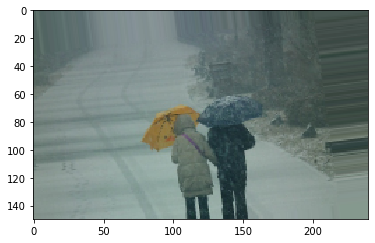

HAZE


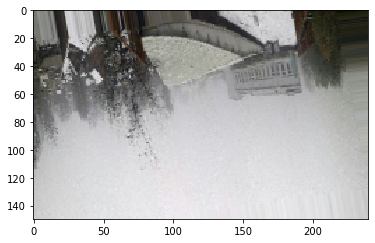

SNOWY


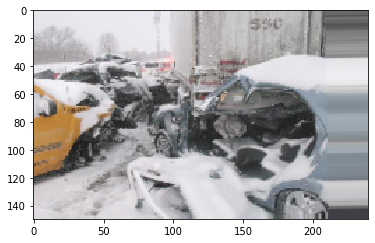

RAINY


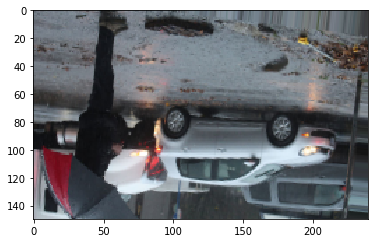

In [0]:
#@title Random Images { vertical-output: true }
n = len(classnames)
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax() 
    print(classnames[label])
    plt.imshow(image)
    plt.show()


In [0]:
#@title Neural Network { vertical-output: true }
def MatNet(input_shape, num_classes):

    model = Sequential()

    # C1 Convolutional Layer --- 2D convolution layer for spatial convolution over images
    # 1. Dimensionality of the output space
    # 2. When using this layer as the first layer in a model, provide the keyword argument input_shape
    # 3. Size of the convolution kernel
    # 4. An integer or tuple/list of 2 integers, specifying the strides of the 
    #    convolution along the height and width. Stride = how much do I slide
    # 5. Padding = keep the same size by adding zeros
    # 6. Activation function
    model.add(Conv2D(32, input_shape=input_shape, kernel_size=(7,7), strides=(3,3), 
                     padding='same', activation='tanh'))
    
    # Invariance to local translations. Reduce the importance of detecting an information
    # in a precise pixel 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    # Normalize the activations of the previous layer at each batch, i.e. applies a transformation 
    # that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    model.add(BatchNormalization())


    # C2 Convolutional Layer 
    model.add(Conv2D(64, kernel_size=(6,6), strides=(2,2), padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())


    # C3 Convolutional Layer
    model.add(Conv2D(96, kernel_size=(2,2), strides=(1,1), padding='valid', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
    model.add(BatchNormalization())


    # Flatten: transforms the data representation from a 3D space to a 1D vector
    model.add(Flatten())
    
    # D1 Dense Layer: regular densely-connected NN layer
    # 1. Number of units
    # 2. Activation function
    model.add(Dense(300, activation='relu'))

    # Dropout consists in randomly setting a fraction of input units to 0 
    # at each update during training time, which helps prevent overfitting.
    model.add(Dropout(0.33))

    model.add(BatchNormalization())


    # D2 Dense Layer
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.33))
    model.add(BatchNormalization())


    # D3 Dense Layer
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())


    # D4 Dense Layer
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())


    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))


    # Compile
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

    return model
 
# create the model
model = MatNet(input_shape,num_classes)
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 80, 32)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 40, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 40, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 20, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 10, 64)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 10, 64)         25

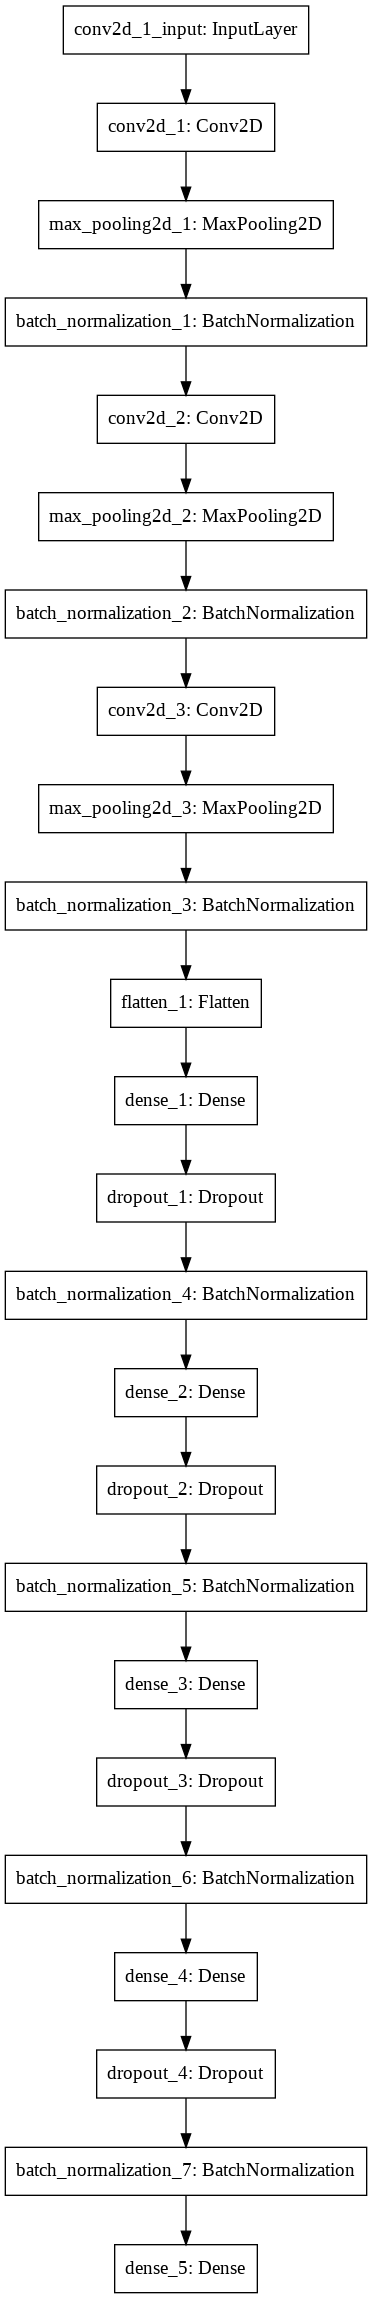

In [0]:
#@title Network Model { vertical-output: true }
tf.keras.utils.plot_model(model)


In [0]:
#@title Training { vertical-output: true }

stopping = EarlyStopping(monitor='val_acc', patience=3)

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    # Trains the model on data generated batch-by-batch by a Python generator
    # 1. Generator that gives tuples, that form batches
    # 2. Integer number of epochs to train the model. An epoch is an iteration over the entire data provided
    # 3. number of steps (batches of samples) to yield from generator before declaring one epoch 
    #    finished and starting the next epoch
    # 4. Generator for the test set
    # 5. Total number of steps (batches of samples) to yield from test generator 
    #    before stopping at the end of every epoch
    history = model.fit_generator(train_generator, epochs=30, verbose=1, \
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=smarti_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/10
31/31 [==============================] - 60s 2s/step - loss: 0.6127 - acc: 0.7671 - val_loss: 1.9293 - val_acc: 0.4422
Epoch 2/10
31/31 [==============================] - 60s 2s/step - loss: 0.5947 - acc: 0.7681 - val_loss: 2.9872 - val_acc: 0.2193
Epoch 3/10
31/31 [==============================] - 60s 2s/step - loss: 0.6232 - acc: 0.7532 - val_loss: 1.8677 - val_acc: 0.3596
Epoch 4/10
31/31 [==============================] - 61s 2s/step - loss: 0.6130 - acc: 0.7692 - val_loss: 2.8194 - val_acc: 0.2074
Epoch 5/10
31/31 [==============================] - 61s 2s/step - loss: 0.5776 - acc: 0.7714 - val_loss: 2.0550 - val_acc: 0.4317
Epoch 6/10
31/31 [==============================] - 59s 2s/step - loss: 0.5979 - acc: 0.7749 - val_loss: 4.4094 - val_acc: 0.1962
Epoch 7/10
31/31 [==============================] - 58s 2s/step - loss: 0.5542 - acc: 0.7928 - val_loss: 2.9230 - val_acc: 0.2025
Epoch 8/10
31/31 [==============================] - 58s 2s/step - loss: 0.5141 - acc: 0.80

In [0]:
#@title Save Model { vertical-output: true }
models_dir = '/content/drive/My Drive/Homework2'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'HW02_MatNet')


Model saved successfully on file /content/drive/My Drive/Homework2/HW02_MatNet.h5



In [0]:
#@title Performance { vertical-output: true }
preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

48/48 [==============================] - 24s 502ms/step
              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.074     0.019     0.030       521
       SNOWY      0.518     0.866     0.648      1421
       SUNNY      0.738     0.144     0.241      1095

    accuracy                          0.461      3037
   macro avg      0.332     0.257     0.230      3037
weighted avg      0.521     0.461     0.396      3037



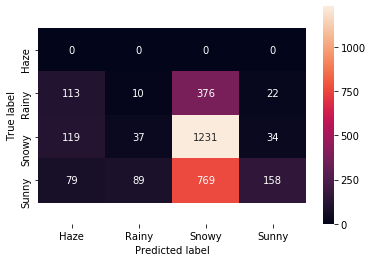

In [0]:
#@title Confusion Matrix { vertical-output: true }
def plot_confusion_matrix(cm, classes):
    cm = pd.DataFrame(cm, index=classes, columns=classes)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

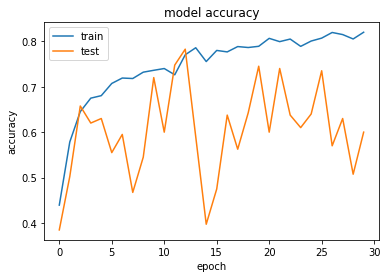

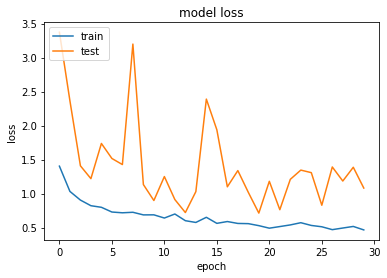

In [0]:
#@title Accuracy and Loss plots { vertical-output: true }
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#@title Transfer Network { vertical-output: true }

# Inception Net
transfer_model = tf.keras.applications.InceptionResNetV2(\
    input_shape=input_shape,include_top=False, weights='imagenet', pooling='avg')
model = tf.keras.Sequential([transfer_model, tf.keras.layers.Flatten(), 
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

# VGG16 Net
#transfer_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',
#                                                   input_shape=input_shape,pooling='max')
#model = tf.keras.Sequential([transfer_model,tf.keras.layers.Flatten(),
#                             tf.keras.layers.Dense(num_classes, activation='softmax')])

optimizer = 'adam'
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
219062272/219055592 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [0]:
#@title Train Transfer Net { vertical-output: true }
# fit the transferNet on the training data
from keras.callbacks import ModelCheckpoint, EarlyStopping

#stopping = EarlyStopping(monitor='val_acc', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

try:
    history_transfer = model.fit_generator(train_generator, epochs=10, verbose=1,
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
31/31 [==============================] - 673s 22s/step - loss: 0.5376 - acc: 0.8049 - val_loss: 10.7883 - val_acc: 0.2500
Epoch 2/10
31/31 [==============================] - 78s 3s/step - loss: 0.2986 - acc: 0.9050 - val_loss: 3.2519 - val_acc: 0.5575
Epoch 3/10
31/31 [==============================] - 76s 2s/step - loss: 0.2326 - acc: 0.9168 - val_loss: 1.1879 - val_acc: 0.6625
Epoch 4/10
31/31 [==============================] - 78s 3s/step - loss: 0.1908 - acc: 0.9427 - val_loss: 0.5552 - val_acc: 0.7550
Epoch 5/10
31/31 [==============================] - 78s 3s/step - loss: 0.2131 - acc: 0.9360 - val_loss: 1.4834 - val_acc: 0.6025
Epoch 6/10
31/31 [==============================] - 78s 3s/step - loss: 0.2518 - acc: 0.9086 - val_loss: 4.7842 - val_acc: 0.4175
Epoch 7/10
31/31 [==============================] - 79s 3s/step - loss: 0.1614 - acc: 0.9416 - val_loss: 1.5001 - val_acc: 

In [0]:
#@title Performance { vertical-output: true }
preds_t = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds_t, axis=1)
Ytest = test_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

7/7 [==============================] - 13s 2s/step
              precision    recall  f1-score   support

        HAZE      0.840     0.890     0.864       100
       RAINY      0.984     0.620     0.761       100
       SNOWY      0.737     0.870     0.798       100
       SUNNY      0.867     0.980     0.920       100

    accuracy                          0.840       400
   macro avg      0.857     0.840     0.836       400
weighted avg      0.857     0.840     0.836       400



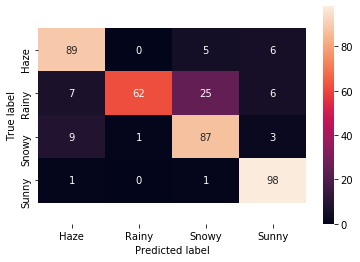

In [0]:
#@title Confusion Matrix { vertical-output: true }
def plot_confusion_matrix(cm, classes):
    cm = pd.DataFrame(cm, index=classes, columns=classes)

    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

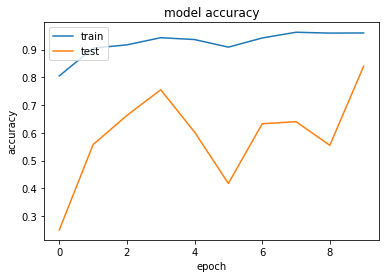

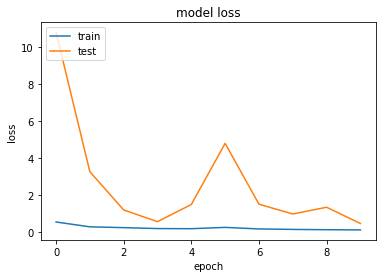

In [0]:
#@title Accuracy and Loss plots { vertical-output: true }

plt.plot(history_transfer.history['acc'])
plt.plot(history_transfer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#@title Save Model { vertical-output: true }
models_dir = '/content/drive/My Drive/Homework2'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'InceptionNet')


Model saved successfully on file /content/drive/My Drive/Homework2/InceptionNet.h5



In [0]:
#@title Performances { vertical-output: true }
#model.predict(smarti_generator)

preds_t = model.predict_generator(smarti_generator)

Ypred = np.argmax(preds_t, axis=1)
Ytest = smarti_generator.classes 
#print(preds_t.shape, Ypred.shape, Ytest.shape)
print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.491     0.265     0.344       521
       SNOWY      0.819     0.783     0.801      1421
       SUNNY      0.716     0.254     0.375      1095

    accuracy                          0.503      3037
   macro avg      0.507     0.325     0.380      3037
weighted avg      0.726     0.503     0.569      3037



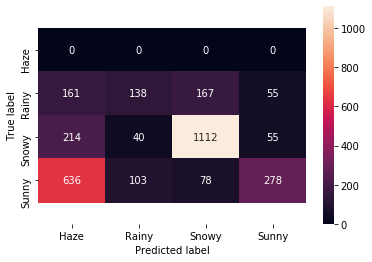

In [0]:
#@title Confusion Matrix { vertical-output: true }
cnf_matrix = confusion_matrix(Ytest, Ypred)
classes = ['Haze', 'Rainy', 'Snowy', 'Sunny']

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

In [0]:
#@title Blind Test Set { vertical-output: true }
blind_set = datadir + '/WeatherBlindTestSet'

blind_datagen = ImageDataGenerator(
    rescale = 1. / 255)

blind_generator = blind_datagen.flow_from_directory(
    directory=blind_set,
    target_size=(150, 240),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# load the best model
model = load_model(datadir+'/InceptionNet.h5')

blind_pred = model.predict(blind_generator)
predictions = np.argmax(blind_pred, axis=1)

In [0]:
#@title Write CSV { vertical-output: true }
def write_csv(pred):
  drive.mount('/content/drive')
  with open('/content/drive/My Drive/Homework2/1695082.csv', 'w') as csv:
    len_p = len(predictions)
    for i in range(0,len_p):
      data = predictions[i]
      if data == 0:
        csv.write('HAZE\n')
      elif data == 1:
        csv.write('RAINY\n')
      elif data == 2:
        csv.write('SNOWY\n')
      elif data == 3:
        csv.write('SUNNY\n')
  drive.flush_and_unmount()
  return 0

write_csv(predictions)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0